## 安裝所需資料庫以及檔案

In [1]:
!gdown --id '1-RMhiBYqSPoRJ3p409vKBskWS1j-MK8C' --output train.csv
!gdown --id '1s_sDNzywiPJD6zGWdPOQFzg8CFkxSjsr' --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1-RMhiBYqSPoRJ3p409vKBskWS1j-MK8C
To: /content/train.csv
36.9MB [00:00, 117MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1s_sDNzywiPJD6zGWdPOQFzg8CFkxSjsr
To: /content/test.csv
56.2MB [00:00, 121MB/s] 


In [3]:
import pandas as pd
import re
import numpy as np
from sklearn.impute import SimpleImputer

## 匯入 train 和 test

In [4]:
data=pd.read_csv('train.csv',encoding='big5')
data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(100000, 132)

In [5]:
data_test = pd.read_csv('test.csv',encoding='big5', low_memory=False)
data_test.shape

(150000, 131)

In [6]:
data.head()

,CUS_ID,GENDER,AGE,CHARGE_CITY_CD,CONTACT_CITY_CD,EDUCATION_CD,MARRIAGE_CD,LAST_A_CCONTACT_DT,L1YR_A_ISSUE_CNT,LAST_A_ISSUE_DT,L1YR_B_ISSUE_CNT,LAST_B_ISSUE_DT,CHANNEL_A_POL_CNT,CHANNEL_B_POL_CNT,OCCUPATION_CLASS_CD,APC_CNT,INSD_CNT,APC_1ST_AGE,INSD_1ST_AGE,IF_2ND_GEN_IND,APC_1ST_YEARDIF,RFM_R,REBUY_TIMES_CNT,LEVEL,RFM_M_LEVEL,LIFE_CNT,IF_ISSUE_A_IND,IF_ISSUE_B_IND,IF_ISSUE_C_IND,IF_ISSUE_D_IND,IF_ISSUE_E_IND,IF_ISSUE_F_IND,IF_ISSUE_G_IND,IF_ISSUE_H_IND,IF_ISSUE_I_IND,IF_ISSUE_J_IND,IF_ISSUE_K_IND,IF_ISSUE_L_IND,IF_ISSUE_M_IND,IF_ISSUE_N_IND,...,FIRST_CANCER_AMT,ILL_ACCELERATION_AMT,ILL_ADDITIONAL_AMT,LONG_TERM_CARE_AMT,MONTHLY_CARE_AMT,IF_HOUSEHOLD_CLAIM_IND,LIFE_INSD_CNT,IF_ISSUE_INSD_A_IND,IF_ISSUE_INSD_B_IND,IF_ISSUE_INSD_C_IND,IF_ISSUE_INSD_D_IND,IF_ISSUE_INSD_E_IND,IF_ISSUE_INSD_F_IND,IF_ISSUE_INSD_G_IND,IF_ISSUE_INSD_H_IND,IF_ISSUE_INSD_I_IND,IF_ISSUE_INSD_J_IND,IF_ISSUE_INSD_K_IND,IF_ISSUE_INSD_L_IND,IF_ISSUE_INSD_M_IND,IF_ISSUE_INSD_N_IND,IF_ISSUE_INSD_O_IND,IF_ISSUE_INSD_P_IND,IF_ISSUE_INSD_Q_IND,IF_ADD_INSD_F_IND,IF_ADD_INSD_L_IND,IF_ADD_INSD_Q_IND,IF_ADD_INSD_G_IND,IF_ADD_INSD_R_IND,IF_ADD_INSD_IND,L1YR_GROSS_PRE_AMT,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G,Y1
0,3418,M,低,A1,A1,NaN,NaN,Y,0,N,0,N,0,0,1.0,0,0,低,低,N,0.046512,低,低,3.0,3.0,中,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,...,NaN,NaN,NaN,NaN,NaN,N,0.015625,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,NaN,NaN,NaN,NaN,NaN,N,0.000174,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,4302,M,低,A1,A1,NaN,NaN,Y,0,N,0,N,0,0,1.0,0,0,低,中,N,0.046512,低,低,5.0,3.0,中,N,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,N,0.015625,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,NaN,NaN,NaN,NaN,NaN,N,0.008724,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,5545,M,低,A1,A1,1.0,0.0,Y,1,Y,0,N,1,0,1.0,1,0,低,中,Y,0.000000,低,低,5.0,3.0,中,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,...,0.00000,0.0,0.0,0.0,0.0,N,0.031250,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,NaN,NaN,NaN,NaN,NaN,N,0.005359,A,Y,N,N,N,N,N,N,N
3,7207,M,低,A1,A1,NaN,0.0,Y,0,N,0,N,0,0,1.0,0,0,低,中,N,0.162791,中高,低,5.0,3.0,中,N,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,N,0.015625,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,NaN,NaN,NaN,NaN,NaN,N,0.000000,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,7213,M,低,A1,A1,1.0,0.0,N,0,N,0,N,1,0,1.0,1,0,低,低,Y,0.116279,中,低,2.0,3.0,中,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,...,0.04717,0.0,0.0,0.0,0.0,Y,0.062500,N,N,N,N,N,Y,N,N,Y,N,N,N,N,Y,N,Y,N,NaN,NaN,NaN,NaN,NaN,N,0.000603,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


## NULL值檢查

In [7]:
pd.isnull(data)
data.dropna(how='all').shape 
#沒有全部皆為NaN值的列
a = data[data.applymap(lambda x: str(x).isspace()) == True].isnull().sum() 
print(data.shape,"\n",sum(a)) #沒有空格欄位

(100000, 132) 
 13200000


In [9]:
data.isnull().sum()

CUS_ID                 0
GENDER               683
AGE                    0
CHARGE_CITY_CD         0
CONTACT_CITY_CD        0
                   ...  
FINANCETOOLS_D     62641
FINANCETOOLS_E     62641
FINANCETOOLS_F     62641
FINANCETOOLS_G     62641
Y1                     0
Length: 132, dtype: int64

In [10]:
data.shape

(100000, 132)

## Categorical columns

In [12]:
object_data = data.select_dtypes(include='object').columns
len(object_data)

90

### 1) ordinal feature (replace NaN with 0)
針對「有序」的類別型 : 使用由小到大的整數作替代，空值用「零值」做填充


In [13]:
def order_features(df):
    order_mapping = {'低':1,'中':2,'中高':3,'高':4}
    col=['AGE','APC_1ST_AGE','INSD_1ST_AGE','RFM_R','REBUY_TIMES_CNT','LIFE_CNT']
    for i in col:
        df[i] = df[i].map(order_mapping)
        df[i] = df[i].fillna(0)
    return df

In [14]:
data_object_1 = order_features(data.copy())

In [15]:
test_object_1 = order_features(data_test.copy())

### 2-1) nominal feature_Y/N (replace NaN with 2)
針對「Y/N」的特徵值 : 用「1/0」數值作替代，空值以「2」做填補

In [16]:
def Y_N(df):
    count = 0
    transform={'Y':1,'N':0}
    for i in df.columns:
        if re.match(r'IF|FINANCETOOLS|X_|IM_IS|LAST|^[A-Z].*IND$', i):
            df[i] = df[i].map(transform)
            df[i] = df[i].fillna(2)
            count+=1
    print("number of Y/N columns ：", count) 
    
    # Using 'try' to make sure not to raise error when fitting test data 
    try:
        df['Y1']=df['Y1'].map(transform)
    except:
        pass

    return df

In [17]:
data_object_2 = Y_N(data_object_1)

number of Y/N columns ： 79


In [18]:
test_object_2 = Y_N(test_object_1)

number of Y/N columns ： 79


In [92]:
#列出所有有NaN值的欄位
nan_col = []
for i in data_object_2.columns:
  if data_object_2[i].isna().any():
    nan_col.append(i)
nan_col

['GENDER',
 'EDUCATION_CD',
 'MARRIAGE_CD',
 'OCCUPATION_CLASS_CD',
 'APC_1ST_YEARDIF',
 'LEVEL',
 'RFM_M_LEVEL',
 'ANNUAL_PREMIUM_AMT',
 'ANNUAL_INCOME_AMT',
 'L1YR_C_CNT',
 'INSD_LAST_YEARDIF_CNT',
 'BMI',
 'TERMINATION_RATE',
 'DIEBENEFIT_AMT',
 'DIEACCIDENT_AMT',
 'POLICY_VALUE_AMT',
 'ANNUITY_AMT',
 'EXPIRATION_AMT',
 'ACCIDENT_HOSPITAL_REC_AMT',
 'DISEASES_HOSPITAL_REC_AMT',
 'OUTPATIENT_SURGERY_AMT',
 'INPATIENT_SURGERY_AMT',
 'PAY_LIMIT_MED_MISC_AMT',
 'FIRST_CANCER_AMT',
 'ILL_ACCELERATION_AMT',
 'ILL_ADDITIONAL_AMT',
 'LONG_TERM_CARE_AMT',
 'MONTHLY_CARE_AMT']

###  2-2) nominal feature_others (make NaN become a kind of category)
針對「名目特徵」: 將空值也當作一種類別進行dummy變數的轉換

ps : 「MARRIAGE_CD」雖然也是屬於數值型態的「0,1,2」，但因為無法做比較所以也做相同處理


In [19]:
def OHE(df):
    col = df.select_dtypes(include='object').columns
    col = col.append(pd.Index(["MARRIAGE_CD"])) # !!! It's a categorical column in float data type !!! 
    print('The remaining categorical columns：', len(col), "\n", col)
    
    c3 = {}
    for c in col:
        c3[c] = 'ohe_' + c
        df[c] = df[c].fillna("NaN") # to make "NaN" also become a kind of category
        
    #df = df.fillna(0)  #if use Fill_NA function
    df = pd.get_dummies(df, columns=col, drop_first=True, prefix=c3)
    
    print('Shape：', df.shape)
    return df

In [20]:
data_object_3 = OHE(data_object_2)

The remaining categorical columns： 5 
 Index(['GENDER', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'CUST_9_SEGMENTS_CD',
       'MARRIAGE_CD'],
      dtype='object')
Shape： (100000, 153)


In [21]:
test_object_3 = OHE(test_object_2)

The remaining categorical columns： 5 
 Index(['GENDER', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'CUST_9_SEGMENTS_CD',
       'MARRIAGE_CD'],
      dtype='object')
Shape： (150000, 152)


### NaN
針對「剩餘數值型」的NaN值 : 使用該欄位的 mean 做填補

In [22]:
def Fill_NaN(df, method):
    imr = SimpleImputer(missing_values = np.nan, strategy=method).fit(df.values)
    imputed_data = imr.transform(df.values)
    
    #turn numpy.ndarray back to dataframe
    col={}
    for j,c in enumerate(df.columns):
        col[c] = imputed_data[:, j]
        
    df = pd.DataFrame(col)
    return df

In [23]:
data_object_final = Fill_NaN(data_object_3, 'mean')
data_test_final = Fill_NaN(test_object_3, 'mean')

## 用 Logistic Regression 做預測

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve

X,y = data_object_final.drop(['Y1','CUS_ID'],axis=1), data_object_final['Y1']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=5699f1c8e9b05ba9fb1fd11d3a8d988660dce75dc55c4220a02c518df5b66ebd
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy import stats
from sklearn import metrics
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import warnings
import time
import gc

In [25]:
lr = LogisticRegression(C=50, class_weight='balanced', random_state=1)
lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=50, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
from sklearn.metrics import accuracy_score  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

score = accuracy_score(y_test, lr.predict(X_test))
roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
#cr = classification_report(y_test, lr.predict(X_test))
print(score)
print(roc)

0.7453333333333333
0.8033034297052154


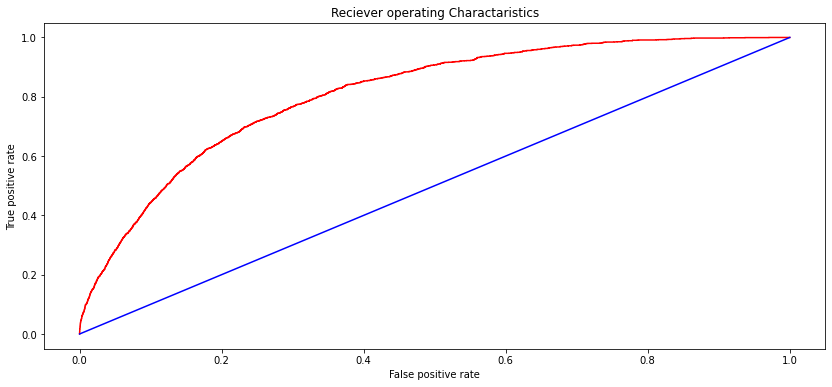

In [27]:
y_pred = lr.predict_proba(X_test)
lr.score(X,y)

#plot
import matplotlib.pyplot as plt
y_proba = lr.predict_proba(X)[:,1]
fpr,tpr,th = roc_curve(y,y_proba)

plt.figure(figsize=(14,6))
plt.plot(fpr,tpr,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## 使用 xgboost 預測

In [28]:
from xgboost.sklearn import XGBClassifier

In [ ]:
#先把dataframe轉成np.array型態
xg_X_train = X_train.values
xg_X_test = X_test.values
xg_y_train = y_train.values
xg_y_test = y_test.values

In [30]:
Xgbc=XGBClassifier(random_state=2019)
Xgbc.fit(xg_X_train,xg_y_train)
y_xgbc_pred=Xgbc.predict(xg_X_test)
Xgbc_score=accuracy_score(xg_y_test,y_xgbc_pred) #準確率

In [31]:
Xgbc_score

0.9799666666666667

In [46]:
Xgbc_auc=roc_auc_score(xg_y_test,y_pred[:,1])

In [47]:
Xgbc_auc

0.840504903628118

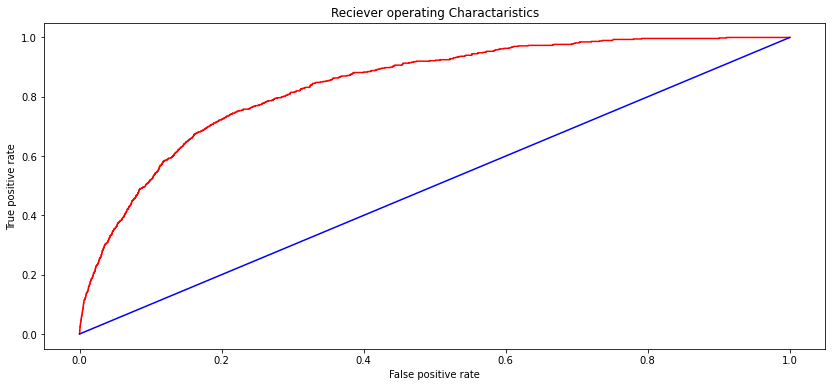

In [39]:
y_pred = Xgbc.predict_proba(xg_X_test)
fpr,tpr,th = roc_curve(xg_y_test,y_pred[:,1])

plt.figure(figsize=(14,6))
plt.plot(fpr,tpr,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(xg_y_test,y_xgbc_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     29400
         1.0       0.45      0.01      0.02       600

    accuracy                           0.98     30000
   macro avg       0.72      0.50      0.50     30000
weighted avg       0.97      0.98      0.97     30000



In [52]:
num_1 = 0
num_0 = 0
for i in y_xgbc_pred:
  if i==0:
    num_0+=1
  elif i==1:
    num_1+=1
print('number of 1 is %d and number of 0 is %d'%(num_1,num_0))

number of 1 is 11 and number of 0 is 29989


In [53]:
num_1 = 0
num_0 = 0
for i in xg_y_test:
  if i==0:
    num_0+=1
  elif i==1:
    num_1+=1
print('number of 1 is %d and number of 0 is %d'%(num_1,num_0))

number of 1 is 600 and number of 0 is 29400


## Test Data

In [ ]:
data_test= pd.read_csv('test.csv',encoding='big5')
data_test = data_test.fillna("NaN")
data_test = OHE(data_test)
data_test = Y_N(data_test)
data_test = order_features(data_test)

imr = imr.fit(data_test.values)
imputed_data = imr.transform(data_test.values)

col={}
for j,c in enumerate(data_test.columns):
    col[c] = imputed_data[:, j]
data_test_final=pd.DataFrame(col)

C:\Users\doggy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Categorical columns in dataset ['GENDER', 'CHARGE_CITY_CD', 'CONTACT_CITY_CD', 'MARRIAGE_CD', 'CUST_9_SEGMENTS_CD']
(150000, 152)


In [ ]:
lr = LogisticRegression(C=50, class_weight='balanced', random_state=1)
X,y = data_final.drop('Y1',axis=1), data_final['Y1']
lr.fit(X,y)
y_pred = lr.predict_proba(data_test_final)[:,1]
#lr.score(X,y)
y_pred_final=pd.Series(y_pred).apply(lambda x: "Y" if x > 0.5 else "N")

#Submit Prediction
submit_test=pd.read_csv('submit_test.csv',encoding='big5')
submit = pd.DataFrame({'CUS_ID':submit_test['CUS_ID'],'Ypred':y_pred_final})
submit.to_csv('test1_SimpleLogistic.csv',index=False)

## Feature Extraction - RandomForest 

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

feat_labels = data_object_final.drop(['Y1','CUS_ID'],axis=1).columns

forest = RandomForestClassifier(n_estimators=1024,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

sfm = SelectFromModel(forest, threshold=0.01, prefit=True)
X_selected = sfm.transform(X_train)

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) DIEBENEFIT_AMT                 0.036341
 2) DIEACCIDENT_AMT                0.036085
 3) INSD_LAST_YEARDIF_CNT          0.033043
 4) ANNUAL_INCOME_AMT              0.029726
 5) L1YR_GROSS_PRE_AMT             0.026913
 6) BMI                            0.025911
 7) ANNUAL_PREMIUM_AMT             0.025588
 8) TOOL_VISIT_1YEAR_CNT           0.025027
 9) APC_1ST_YEARDIF                0.022976
10) INSD_1ST_AGE                   0.018152
11) ACCIDENT_HOSPITAL_REC_AMT      0.018071
12) INPATIENT_SURGERY_AMT          0.016216
13) LIFE_INSD_CNT                  0.015859
14) EDUCATION_CD                   0.015507
15) OCCUPATION_CLASS_CD            0.015470
16) ANNUITY_AMT                    0.015453
17) CHANNEL_A_POL_CNT              0.015218
18) DISEASES_HOSPITAL_REC_AMT      0.014891
19) OUTPATIENT_SURGERY_AMT         0.014598
20) MONTHLY_CARE_AMT               0.013365
21) FIRST_CANCER_AMT               0.012659
22) AGE                            0.012021
23) IM_CNT                      

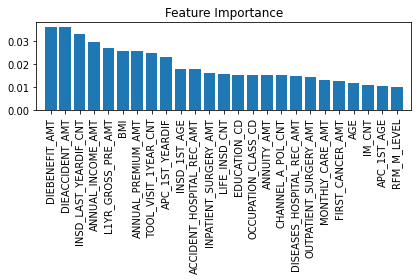

In [64]:
plt.title('Feature Importance')
plt.bar(range(X_selected.shape[1]), 
        importances[indices[range(X_selected.shape[1])]],
        align='center')

plt.xticks(range(X_selected.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_selected.shape[1]])
plt.tight_layout()

plt.show()

In [65]:
new_col=feat_labels[indices[range(X_selected.shape[1])]]
X,y = data_object_final[new_col], data_object_final['Y1']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
xg_X_train, xg_X_test, xg_y_train, xg_y_test = X_train.values, X_test.values, y_train.values, y_test.values
Xgbc=XGBClassifier(random_state=2019)
Xgbc.fit(xg_X_train,xg_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
y_xgbc_pred=Xgbc.predict(xg_X_test)
Xgbc_score=accuracy_score(xg_y_test,y_xgbc_pred) #準確率
y_pred = Xgbc.predict_proba(xg_X_test)
Xgbc_auc=roc_auc_score(xg_y_test,y_pred[:,1])
print('accuracy is %f and roc is %f'%(Xgbc_score,Xgbc_auc))

accuracy is 0.979967 and roc is 0.832039


In [67]:
new_col=feat_labels[indices[range(X_selected.shape[1])]]
X,y = data_object_final[new_col], data_object_final['Y1']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
lr = LogisticRegression(C=50, class_weight='balanced', random_state=1)
lr.fit(X_train,y_train)
roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [68]:
roc

0.7577489229024943